In [2]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from paper.systems.simplesystem import simplesystem
import pandas as pd
import numpy as np
from seaborn import heatmap
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
from sysquant.estimators.diversification_multipliers import diversification_mult_single_period
from sysquant.optimisation.weights import portfolioWeights
from syslogdiag.log_to_screen import logtoscreen
import matplotlib.colors as mcolors

log = logtoscreen('csvFuturesSimData')
log.set_logging_level('close eye')
# data = csvFuturesSimData()
data =  csvFuturesSimData(csv_data_paths=dict(
            csvFuturesAdjustedPricesData='ctse.data.adjusted_prices_csv',
            csvFuturesMultiplePricesData='ctse.data.multiple_prices_csv',
            csvFuturesInstrumentData='ctse.data.csvconfig'
    ), log=log)
system = simplesystem(
    data,
    'paper.systems.china.yaml')
data = system.data

NameError: name 'instrument_code' is not defined

0.38774697361291166


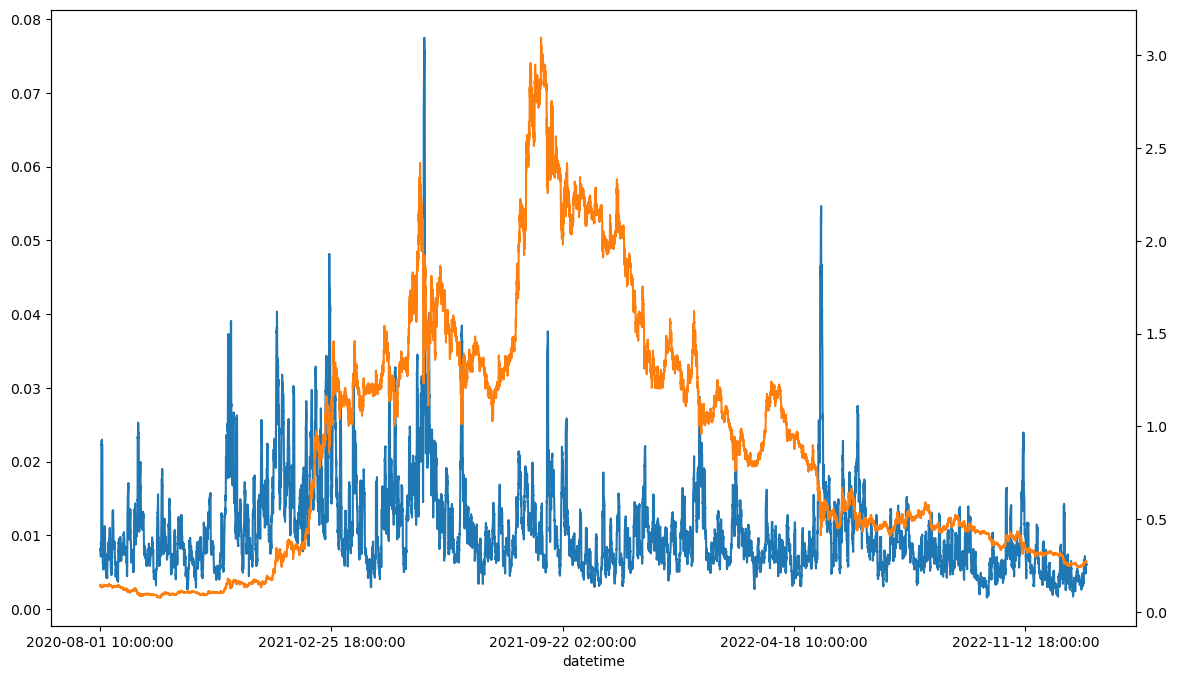

In [74]:
from syscore.fileutils import get_filename_for_package
from paper.systems.rules.mac import mac
from paper.systems.rules.mac import ewmac
import pandas as pd
def select(df):
    return df[(df.index > '2022-03-09') & (df.index < '2022-04-03')]
    # return df

symbol = 'ADA-USDT-SWAP'
price = pd.read_csv(get_filename_for_package('paper.data.{}.csv'.format(symbol)), index_col=0).iloc[:, 0]

from sysquant.estimators.vol import simple_vol_calc, simple_ewvol_calc
returns = price.pct_change()
vol = simple_vol_calc(returns).rename('vol')
# vol = simple_ewvol_calc(returns).rename('vol')
vol.plot(figsize=(14, 8))
price.plot(secondary_y='close')
import statsmodels.api as sm

future_vol = simple_vol_calc(returns.shift(-25)).rename('future_vol')
samples = pd.concat([vol, future_vol], axis=1).dropna()
x = sm.add_constant(samples.vol)
y = samples.future_vol
rsquared = sm.OLS(y, x).fit().rsquared_adj
print(rsquared)

# ewmac_forecast = ewmac(price, 8, 32).rename('ewmac')
# ewmac_forecast = 10 * ewmac_forecast / abs(ewmac_forecast).mean()
# ewmac_forecast = ewmac_forecast.clip(-20, 20)
# ewmac_forecast.plot()

# select(pd.concat([price, mac_forecast, ewmac_forecast], axis=1)).plot(secondary_y='close', figsize=(14, 8), alpha=0.5)
# print(48000 / 38000 - 1)

2172
2172
2031
2031


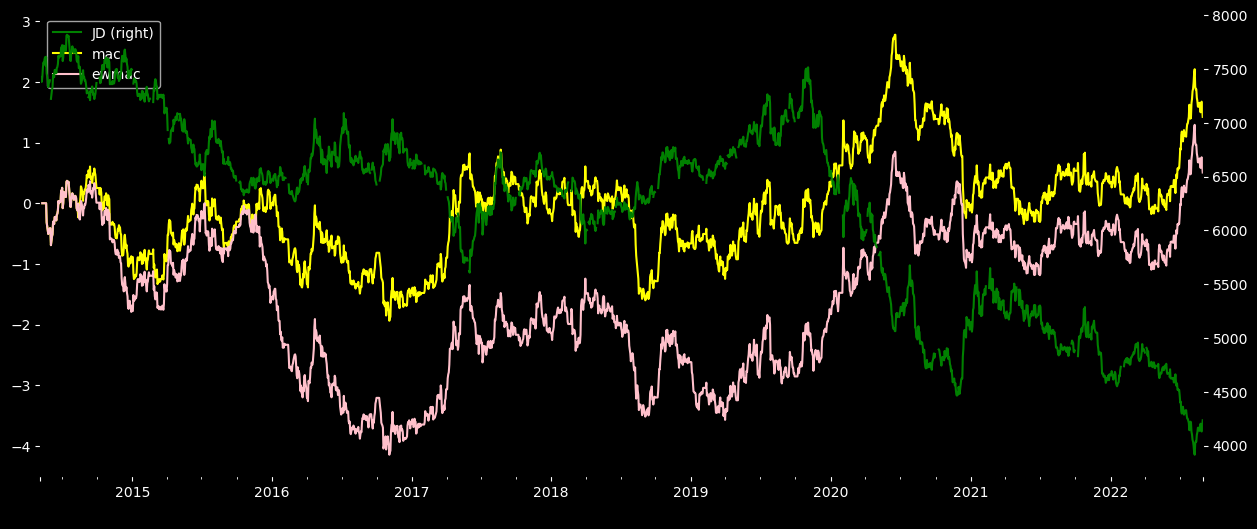

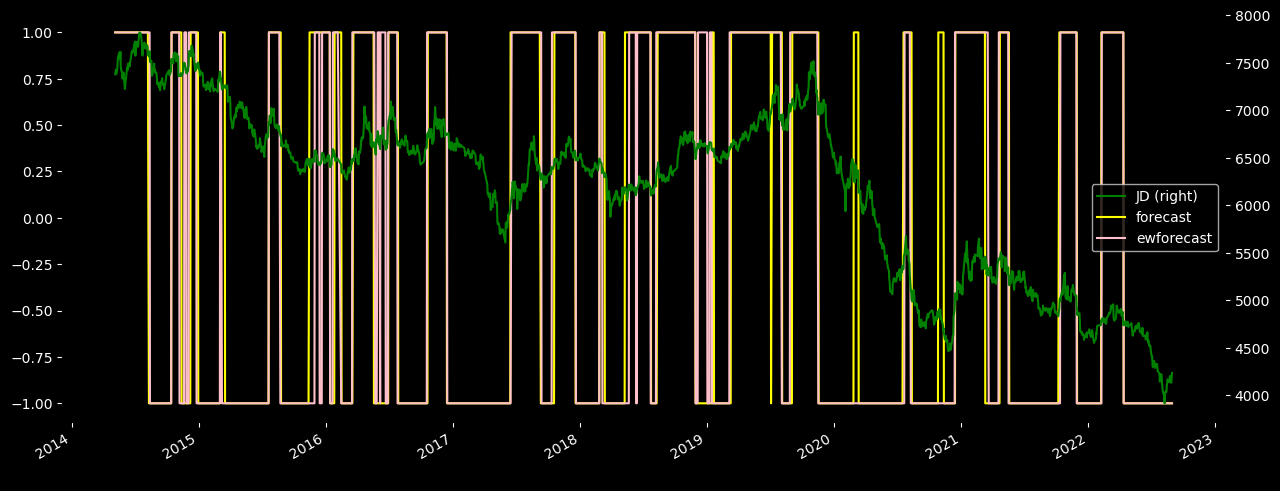

In [16]:
from paper.systems.rules.mac import mac
from paper.systems.rules.mac import ewmac

instrument_code = 'JD'
fast = 10
slow = 4 * fast

price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
forecast = mac(price, fast, slow).rename('forecast')


price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
ewforecast = ewmac(price, fast, slow).rename('ewforecast')

forecast_df = pd.concat([price, forecast, ewforecast], axis=1)
forecast_df = forecast_df.tail(len(forecast_df) - 2 * slow)

from systems.accounts.account_forecast import pandl_for_instrument_forecast

def select(df):
    return df
    # return df[(df.index > '2016-01-01') & (df.index < '2020-01-01')]

account = pandl_for_instrument_forecast(forecast=forecast_df.forecast, price = forecast_df[instrument_code])
ewaccount = pandl_for_instrument_forecast(forecast=forecast_df.ewforecast, price = forecast_df[instrument_code])
print(len(ewaccount))
print(len(account))
print(len(forecast_df[instrument_code]))
print(len(forecast_df.ewforecast))

pl = account.curve().rename('mac')
ewpl = ewaccount.curve().rename('ewmac')
pl_df = pd.concat([forecast_df[instrument_code], pl, ewpl], axis=1)
pl_df = select(pl_df)
ax = pl_df.plot(secondary_y=instrument_code, figsize=(15,6), color=['green', 'yellow', 'pink'])

forecast_df = select(forecast_df)
plt.show()
ax = forecast_df.plot(figsize=(15,6), color=['green', 'yellow', 'pink'], secondary_y=instrument_code)

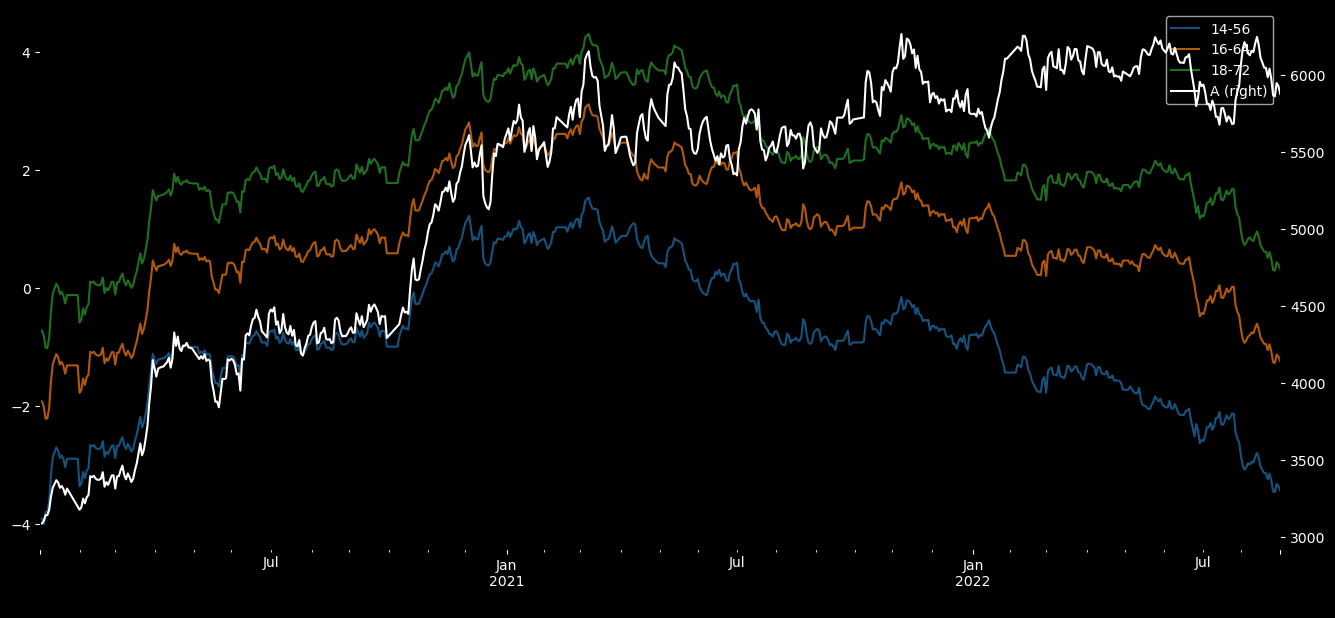

A


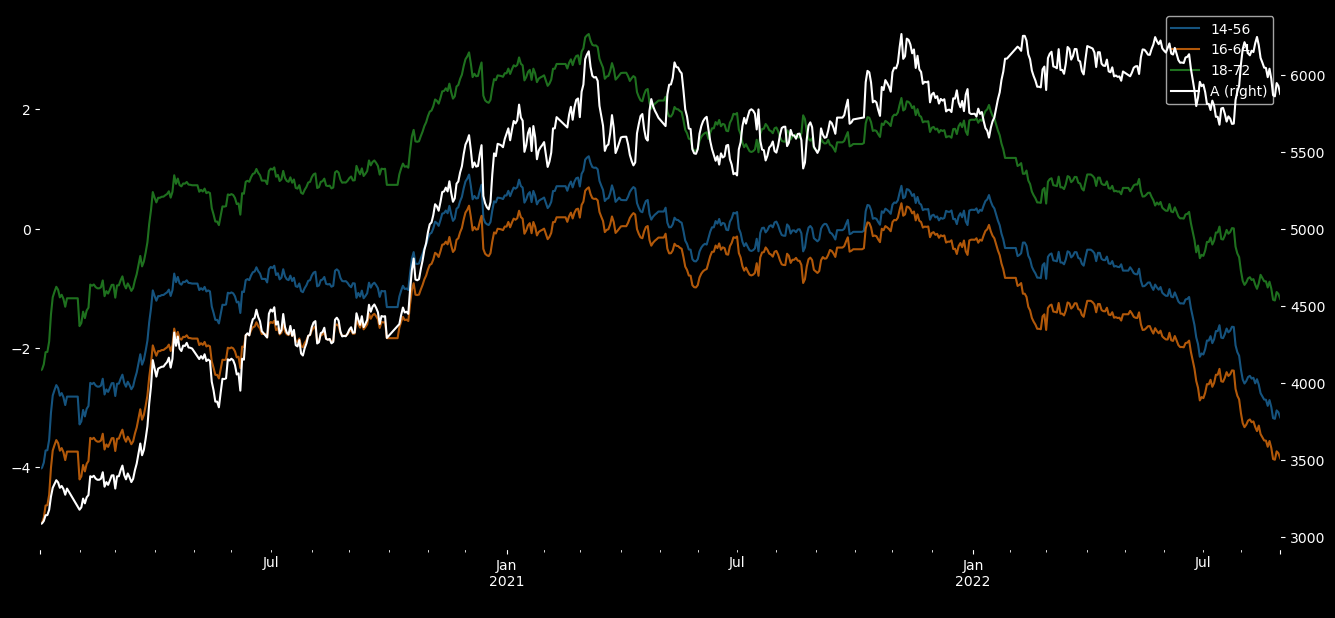

A


In [236]:
from paper.systems.rules.mac import mac
from paper.systems.rules.mac import ewmac
from systems.accounts.account_forecast import pandl_for_instrument_forecast

def select(df):
    # return df
    return df[(df.index > '2020-01-01') & (df.index < '2023-01-01')]

def simulate(instrument_code, filter, fast_range1):
    color_list = list(mcolors.TABLEAU_COLORS.values())
    assert len(color_list) >= len(fast_range1)
    color_list = color_list[:len(fast_range1)]

    pl_df_list = []
    forecast_df_list = []
    for fast in fast_range1:
        slow = 4 * fast

        price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
        forecast = filter(price, fast, slow).rename('forecast{}'.format(slow))
        forecast_df_list.append(forecast)

        price = data.daily_prices(instrument_code).rename(instrument_code).dropna()

        forecast_df = pd.concat([price, forecast], axis=1)
        forecast_df = forecast_df.tail(len(forecast_df) - 2 * slow)

        account = pandl_for_instrument_forecast(forecast=forecast_df['forecast{}'.format(slow)], price = forecast_df[instrument_code])

        pl = account.curve().rename('{}-{}'.format(fast, slow))
        pl_df_list.append(pl)
        
    ax = plt.subplot()
    pl_df_list = pd.concat(pl_df_list, axis=1)
    pl_df_list = select(pl_df_list)
    _ = pl_df_list.plot(secondary_y=instrument_code, ax=ax, figsize=(16,7), color=color_list, alpha=0.7)
    # forecast_df = select(forecast_df[instrument_code])

    price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
    price = select(price)
    price.plot(ax=ax, secondary_y=True, legend=True, color='white')
    plt.show()

    turnover = pd.concat(forecast_df_list, axis=1)
    trades = ((turnover.replace(np.nan, 0).diff() != 0) * 1).sum()
    years = np.abs((turnover.apply(lambda se:se.first_valid_index()) - turnover.last_valid_index()) / pd.Timedelta(365, 'D'))
    avg_hold_days = 12 * 4 * 5 / (trades / years)
    print(instrument_code)
    # display(avg_hold_days)

instrument_code = pd.Series(system.get_instrument_list()).sample(1).iloc[0]
instrument_code = 'A'
# fast_range1 = [2, 3, 4, 5, 6, 7, 8, 9, 18, 22]
fast_range1 = [14, 16, 18]
filter = ewmac
simulate(instrument_code, filter, fast_range1)
simulate(instrument_code, mac, fast_range1)

In [206]:
len(fast_range1)

12

<AxesSubplot:>

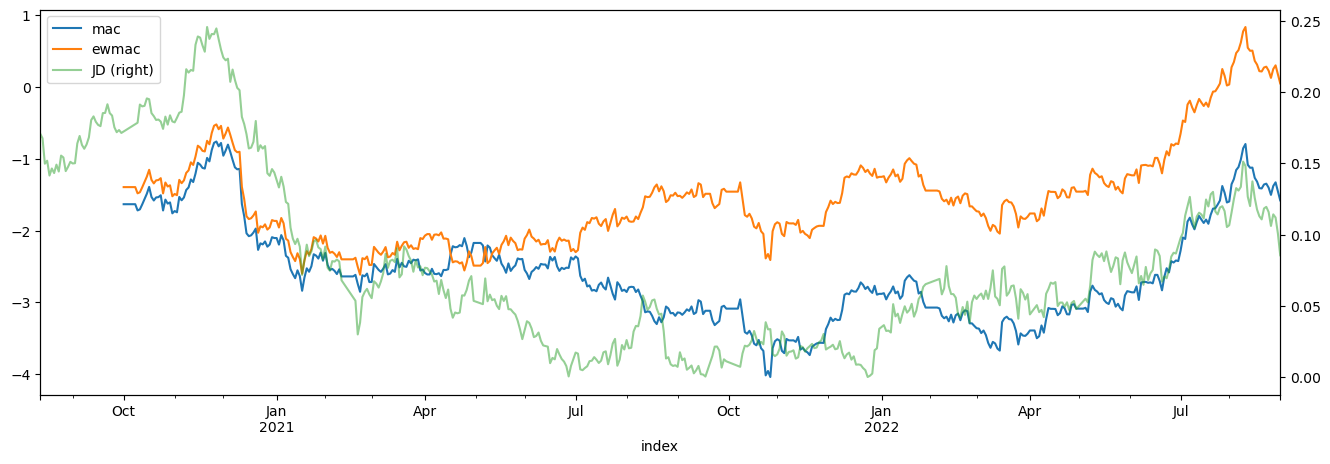

In [4]:
pl.tail(500).plot(legend=True, figsize=(16,5))
ewpl.tail(500).plot(legend=True)
# price.head(500).plot(legend=True, secondary_y=True)

from mdi import rolling_snr
snr = rolling_snr(price.ffill(), slow)
snr.tail(500).plot(legend=True, secondary_y=True, alpha=0.5)